In [2]:
###CNN and MLP primitive

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##The encoder in the paper takes x in R^(TxHxW) and y in R^(TxE) and maps them to R^(TxL) the dimensionality of the context encoder
##and encoder is set to 5. So this cnn needs to output (32x5) so each (surface in R^(5x5) -> (z in R^5)

##we enhance the dimensionality of the iv surface first by upgrading the number of channels. The reasoning behind this is similar to why 
##we do this in transformer architecture. A larger dimensional space will be able to capture more nuanced information and represent it in number form
##then we compress this to something digestable
class CNN(nn.Module):
    #input_size and output_size represent the number of channels in the input and output data
    #channels is the number of dimensions a single data point will have ie RGB = 3 channelss
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_size, output_size, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(output_size, output_size, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(output_size, output_size, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(output_size * 5 * 5, 5)

    def forward(self, x):
       # print(x.shape)
        H, W = x.shape
        x = x.reshape(1, 1, H, W) #batch, channels, H, W
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(1, -1)
        x = self.fc(x)
        return x

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, y):
        x = F.relu(self.fc1(y))
        x = self.fc2(y)
        return y

In [3]:
###CNN For decoder 

#due to difference in dimensionality - What happened st i needed to make this. z, zeta make different shape so needed redfinition
##plus it will define a new coniditional probability distribtution

##had to make another cnn for decoder due difference in dimensionality

##in here the output size should be the number of days in the future?

##for now output_size = 1 so we predict 1 day into the future?
class TCNN(nn.Module):
    def __init__(self, input_size, output_size, num_surfaces):
        super(TCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 5 * 5 * num_surfaces)
        self.output_size = output_size
        self.num_surfaces = num_surfaces
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, self.num_surfaces, 5, 5)
        return x

In [4]:
###ENCODER DECODER CONTEXTENCODER

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.cnn = CNN(input_size, 5)
        self.mlp = nn.Identity()
        self.lstm = nn.LSTM(5 + 3, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.linear_mu = nn.Linear(hidden_size, latent_size)
        self.linear_sigma = nn.Linear(hidden_size, latent_size)

    def forward(self, x, y):
        N = x.shape[0]
        z = []
        mu = []
        log_var = []
        for i in range(0, N):
            x_i = x[i]
            y_i = y[i]
             #represent surfaces and extra features as a compressed vector
            x_encoded = self.cnn(x_i) #consume one at a time
            y_encoded = self.mlp(y_i)
            #print(x_encoded.shape)
            #print(y_encoded.shape)
            encoded = torch.cat((x_encoded, y_encoded), dim=1) 

            #produce the next hidden state
            _, (hidden, _) = self.lstm(encoded)
            hidden = hidden[-1]  

            #use hidden state to produce parameters
            mu_hat = self.linear_mu(hidden)
            log_var_hat = self.linear_sigma(hidden)

            #sample from distribution
            z_hat = self.reparameterize(mu_hat, log_var_hat)
            mu.append(mu_hat)
            log_var.append(log_var_hat)
            z.append(z_hat)
        #return representation¢
        return z, mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

class ContextEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, context_size):
        super(ContextEncoder, self).__init__()
        self.cnn = CNN(input_size, 5)
        self.mlp = nn.Identity()
        self.lstm = nn.LSTM(5 + 3, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_size, context_size)

    #def forward(self, x_c, y_c):
        #x_encoded = self.cnn(x_c)
        #y_encoded = self.mlp(y_c)
        #y_encoded = torch.squeeze(y_encoded, dim=1)
        #print(f"x_encoded size = {x_encoded.shape} ||y_encoded size = {y_encoded.shape}")
        #encoded = torch.cat((x_encoded, y_encoded), dim=-1)
        #_, (hidden, _) = self.lstm(encoded)
        #hidden = hidden[-1]  # Take the last hidden state
        #zeta = self.linear(hidden)
        #print("context encoding successful")
        #return zeta

    def forward(self, x, y):
        N = x.shape[0]
        zeta = []
        for i in range(0, N):
            x_i = x[i]
            y_i = y[i]
            #represent surface and extra features
             #represent surfaces and extra features as a compressed vector
            x_encoded = self.cnn(x_i) #consume one at a time
            y_encoded = self.mlp(y_i)
            encoded = torch.cat((x_encoded, y_encoded), dim=1) 

            #produce the next hidden state
            _, (hidden, _) = self.lstm(encoded)
            hidden = hidden[-1]  

            #context representation
            zeta_hat = self.linear(hidden)
            zeta.append(zeta_hat) 
        return zeta

class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size, num_surfaces):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(310, hidden_size, num_layers=2, batch_first=True, dropout=0.2) #latent
        self.tcnn = TCNN(hidden_size, output_size, num_surfaces)
        self.mlp = nn.Linear(hidden_size, 1)

    #we only reconstruct the future surfaces
    def forward(self, z, zeta):
        z_tensor = torch.cat(z, dim=0).view(1,-1)  # concatenate z tensors into one big tensor
        zeta_tensor = torch.cat(zeta, dim=0).view(1,-1)

        #print(z_tensor.shape)
        #print(zeta_tensor.shape)
        cell =  torch.cat((z_tensor, zeta_tensor), dim=1)

       # print(cell.shape)
        hidden, _ = self.lstm(cell)
        x_n = self.tcnn(hidden)
        r_n = self.mlp(hidden)

        return x_n, r_n
        
   # def forward(self, z, zeta):
        # Reshape z and zeta to have shape (1, 31)
     #   z = z.view(1, -1)
      #  zeta = zeta.view(1, -1)
        # Concatenate z and zeta along the second dimension to get shape (1, 10)
       # z_concat = torch.cat((z, zeta), dim=1)
        
        #print(f"z_concat is of size {z_concat.shape}")
        #x_n = self.tcnn(hidden) 
        #hidden, _ = self.lstm(z_concat)
        #print('i am here')
        #r_n = self.mlp(hidden)
        #print("decoding successful")
        #return torch.squeeze(x_n, dim=0), torch.squeeze(r_n, dim=0)

In [5]:
# Moneyness levels and time to maturity (in days ##based of paper single skew and slope for surface
moneyness_levels = [0.7, 0.85, 1, 1.15, 1.3]
ttm_levels = [1, 3, 6, 12, 24] #days

def calculate_skew_slope(iv_row):
    # Select IV values for the specific TTM and moneyness levels
    iv_12d_085 = iv_row.get((12, 0.85), 0)  # IV for 1 year TTM and moneyness=0.85
    iv_12d_100 = iv_row.get((12, 1.00), 0)  # IV for 1 year TTM and moneyness=1.00
    iv_12d_115 = iv_row.get((12, 1.15), 0)  # IV for 1 year TTM and moneyness=1.15

    # Calculate skew
    skew = (iv_12d_085 + iv_12d_115) / 2 - iv_12d_100 if iv_12d_100 else 0  # Avoid division by zero

    # Select IV values for slope calculation
    iv_3d_100 = iv_row.get((3, 1.00), 0)  # IV for 3 months TTM and moneyness=1.00
    iv_24d_100 = iv_row.get((24, 1.00), 0)  # IV for 2 years TTM and moneyness=1.00

    # Calculate slope
    slope = iv_24d_100 - iv_3d_100

    return skew, slope

In [6]:
###CVAE

class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, context_size, output_size, num_surfaces):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.context_encoder = ContextEncoder(input_size, hidden_size, context_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size, num_surfaces)
        self.latent_size = latent_size
        self.context_size = context_size

    def forward(self, x, y, x_c, y_c):
        z, mu, log_var = self.encoder(x, y) ##we have sampled z from distribution here
        zeta = self.context_encoder(x_c, y_c) ##we have sampled zeta from distribution here
        x_n, r_n = self.decoder(z, zeta)
        return x_n, r_n, mu, log_var

    
    def generate(self, x_c, y_c):
        # reasing z and context
        z = torch.tensor(np.array([np.random.normal(loc=0, scale=1, size=5)]), dtype=torch.float32)
        zeta = self.context_encoder(x_c, y_c)
        x_hat, r_hat = self.decoder(z, zeta)
    
        return x_hat, r_hat

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load the DataFrame from the CSV file
df = pd.read_csv('cvae_training_data.csv')

# Extract IV surfaces and reshape them into 5x5 matrices
X = np.array([np.fromstring(iv_surface[1:-1], sep=' ').reshape(5, 5) for iv_surface in df['iv_surface_flattened']])
Y = df[['skew', 'slope', 'log_returns']].values

# Normalize features
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Flatten the IV surfaces for scaling, then reshape back to (5, 5)
X_flat = np.array([surface.flatten() for surface in X])
X_scaled = scaler_x.fit_transform(X_flat).reshape(-1, 5, 5)
Y_scaled = scaler_y.fit_transform(Y)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, Y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4182, 5, 5)
X_val shape: (896, 5, 5)
X_test shape: (897, 5, 5)
y_train shape: (4182, 3)
y_val shape: (896, 3)
y_test shape: (897, 3)


In [8]:
import random

def generate_random_day(n):
    """
    Generates a random number between 1 and n
    """
    # Generate a random number between 1 and n
    random_number = random.randint(1, n - 1)
    return random_number

In [9]:
###PREPARE DATA

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils import mkldnn as mkldnn_utils

# Hyperparameters
hidden_size = 100
latent_size = 5
context_size = 5
input_size = 1
output_size = 5
learning_rate = 1e-3
num_epochs = 500
batch_size = 32
alpha = 0.1
beta = 1e-5


# Reshape the input data to the desired 5-dimensional shape
batch_size_train = X_train.shape[0]
batch_size_val = X_val.shape[0]
batch_size_test = X_test.shape[0]
sequence_length = 1  # 
num_surfaces = 1  # the number of surfaces to generate


H = 5  # Height of the IV surface grid
W = 5  # Width of the IV surface grid

#print(X_train.shape)
X_train_reshaped = X_train.reshape(batch_size_train,  H, W)
X_val_reshaped = X_val.reshape(batch_size_val, H, W)
X_test_reshaped = X_test.reshape(batch_size_test, H, W)
#print(X_train_reshaped.shape)
extra_features_size = 3

y_train_reshaped = y_train.reshape(y_train.shape[0], 1, extra_features_size)
y_val_reshaped = y_val.reshape(y_val.shape[0], 1, extra_features_size)
y_test_reshaped = y_test.reshape(y_test.shape[0], 1, extra_features_size)

train_data = TensorDataset(torch.Tensor(X_train_reshaped), torch.Tensor(y_train_reshaped))
val_data = TensorDataset(torch.Tensor(X_val_reshaped), torch.Tensor(y_val_reshaped))
test_data = TensorDataset(torch.Tensor(X_test_reshaped), torch.Tensor(y_test_reshaped))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Create the model
model = CVAE(input_size, hidden_size, latent_size, context_size, output_size, num_surfaces)

In [1]:
###TRAIN MODEL

num_epochs = 500
def loss_function(x_n, x_n_recon, r_n, r_n_recon, mu, log_var):
    # Ensure x_n and r_n are unsqueezed if needed (depends on data shape handling in other parts of your code)
    x_n = torch.unsqueeze(x_n, dim=0) if len(x_n.shape) < 3 else x_n
    r_n = torch.unsqueeze(r_n, dim=0) if len(r_n.shape) < 3 else r_n
    
    # Calculate the mean squared error, normalized by the number of elements (H*W)
    recon_loss_x = F.mse_loss(x_n_recon, x_n, reduction='mean') / (H * W)
    recon_loss_r = F.mse_loss(r_n_recon, r_n, reduction='mean')

    mu = torch.stack(mu)
    log_var = torch.stack(log_var)
    
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    total_loss = recon_loss_x + alpha * recon_loss_r + beta * kl_loss
    
    return total_loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        batch_size = x.shape[0] #batch_size, context_length, num_surfaces, H, W = x.shape
        
        t = batch_size - num_surfaces - 1

        x_c, x_n = x[:t, :], x[t:, :]
        y_c, y_n = y[:t, :], y[t:, :]
            
        r_n = y_n[:, :, 0]
        
        x_n_recon, r_n_recon, mu, log_var = model(x, y, x_c, y_c)
        
        # Compute the loss
        loss = loss_function(x_n[0], x_n_recon, r_n[0], r_n_recon, mu, log_var)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            batch_size = x.shape[0]  # Number of days in the sequence
            
            # Generate a random day t to split the sequence into context and future
            #t = generate_random_day(batch_size)
            t = batch_size - num_surfaces - 1
            
            x_c, x_n = x[:t, :], x[t:, :]
            y_c, y_n = y[:t, :], y[t:, :]
            
            # Extract the log return feature from y_n
            r_n = y_n[:, :, 0]
            
            x_n_recon, r_n_recon, mu, log_var = model(x, y, x_c, y_c)
            #print(f"x_n_recon: {x_n_recon}")
            
            # Compute the loss
            loss = loss_function(x_n[0], x_n_recon, r_n[0], r_n_recon, mu, log_var)
            
            val_loss += loss.item()
    
    # Print the losses for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
    
    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'new_model.pth')

# Testing
model.load_state_dict(torch.load('new_model.pth'))
model.eval()

NameError: name 'optim' is not defined

In [201]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterSampler, KFold

# Hyperparameters
input_size = 25
context_size = 5
input_size = 1
output_size = 1

# Reshape the input data to the desired 5-dimensional shape
batch_size_train = X_train.shape[0]
batch_size_test = X_test.shape[0]

sequence_length = 1
num_surfaces = 1  # the number of surfaces to generate
H = 5  # Height of the IV surface grid
W = 5  # Width of the IV surface grid

X_train_reshaped = X_train.reshape(batch_size_train, H, W)
X_test_reshaped = X_test.reshape(batch_size_test, H, W)

extra_features_size = 3
y_train_reshaped = y_train.reshape(y_train.shape[0], 1, extra_features_size)
y_test_reshaped = y_test.reshape(y_test.shape[0], 1, extra_features_size)

train_data = TensorDataset(torch.Tensor(X_train_reshaped), torch.Tensor(y_train_reshaped))
test_data = TensorDataset(torch.Tensor(X_test_reshaped), torch.Tensor(y_test_reshaped))

# Create the model
model = CVAE(input_size, hidden_size, latent_size, context_size, output_size, num_surfaces)

def loss_function(x_n, x_n_recon, r_n, r_n_recon, mu, log_var):
    # Ensure x_n and r_n are unsqueezed if needed (depends on data shape handling in other parts of your code)
    x_n = torch.unsqueeze(x_n, dim=0) if len(x_n.shape) < 3 else x_n
    r_n = torch.unsqueeze(r_n, dim=0) if len(r_n.shape) < 3 else r_n

    # Calculate the mean squared error, normalized by the number of elements (H*W)
    recon_loss_x = F.mse_loss(x_n_recon, x_n, reduction='mean') / (H * W)
    recon_loss_r = F.mse_loss(r_n_recon, r_n, reduction='mean')

    # Calculate the Kullback-Leibler divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Combine the losses with the scaling factors
    total_loss = recon_loss_x + alpha * recon_loss_r + beta * kl_loss

    return total_loss

param_distributions = {
    #'hidden_size': [50, 100, 200, 300],
   # 'latent_size': [5, 10, 20],
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'alpha': [0.1, 0.5, 1.0],
    'beta': [1e-5, 5e-6, 1e-6],
    #'batch_size': [16, 32, 64]
}

num_epochs = 100
num_iterations = 5
random_search = ParameterSampler(param_distributions, n_iter=num_iterations, random_state=42)

# Initialize variables to store the best hyperparameters and validation loss
best_hyperparameters = None
best_val_loss = float('inf')

# Define the number of folds for cross-validation
num_folds = 2

# Create a KFold object for cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Iterate over each combination of hyperparameters
for params in random_search:
    #hidden_size = params['hidden_size']
    #latent_size = params['latent_size']
    learning_rate = params['learning_rate']
    alpha = params['alpha']
    beta = params['beta']
    #batch_size = params['batch_size']
    print(f"Hyperparameters: {params}")

    # Initialize variables to store the total validation loss across all folds
    total_val_loss = 0.0

    # Perform k-fold cross-validation
    for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train_reshaped)):
        print(f"Fold {fold + 1}/{num_folds}")

        # Create data subsets for the current fold
        train_subset = TensorDataset(torch.Tensor(X_train_reshaped[train_indices]), torch.Tensor(y_train_reshaped[train_indices]))
        val_subset = TensorDataset(torch.Tensor(X_train_reshaped[val_indices]), torch.Tensor(y_train_reshaped[val_indices]))

        # Create data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Create the model with the current hyperparameters
        model = CVAE(input_size, hidden_size, latent_size, context_size, input_size, num_surfaces)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0.0
            for batch in train_loader:
                x, y = batch
                batch_size = x.shape[0]  # batch_size, context_length, num_surfaces, H, W = x.shape

                # Generate a random day t to split the sequence into context and future
                t = batch_size - num_surfaces - 1

                x_c, x_n = x[:t, :], x[t:, :]
                y_c, y_n = y[:t, :], y[t:, :]
                r_n = y_n[:, :, 0]

                x_n_recon, r_n_recon, mu, log_var = model(x, y, x_c, y_c)

                # Compute the loss
                loss = loss_function(x_n[0], x_n_recon, r_n[0], r_n_recon, mu, log_var)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    x, y = batch
                    batch_size = x.shape[0]  # Number of days in the sequence

                    # Generate a random day t to split the sequence into context and future
                    t = batch_size - num_surfaces - 1

                    x_c, x_n = x[:t, :], x[t:, :]
                    y_c, y_n = y[:t, :], y[t:, :]

                    # Extract the log return feature from y_n
                    r_n = y_n[:, :, 0]

                    x_n_recon, r_n_recon, mu, log_var = model(x, y, x_c, y_c)

                    # Compute the loss
                    loss = loss_function(x_n[0], x_n_recon, r_n[0], r_n_recon, mu, log_var)
                    val_loss += loss.item()

            # Print the losses for each epoch
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

        # Accumulate the validation loss for the current fold
        total_val_loss += val_loss

    # Calculate the average validation loss across all folds
    avg_val_loss = total_val_loss / num_folds

    # Check if the current hyperparameters yield a better validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_hyperparameters = params
        print(best_hyperparameters)

# Print the best hyperparameters and validation loss
print("Best Hyperparameters:")
print(best_hyperparameters)
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Train the final model with the best hyperparameters on the entire training set
best_model = CVAE(input_size, best_hyperparameters['hidden_size'], best_hyperparameters['latent_size'],
                  context_size, input_size, num_surfaces)
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparameters['learning_rate'])

train_loader = DataLoader(train_data, batch_size=best_hyperparameters['batch_size'], shuffle=True)

for epoch in range(1, 1000):
    # Training
    best_model.train()
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        batch_size = x.shape[0]  # batch_size, context_length, num_surfaces, H, W = x.shape

        # Generate a random day t to split the sequence into context and future
        t = batch_size - num_surfaces - 1

        x_c, x_n = x[:t, :], x[t:, :]
        y_c, y_n = y[:t, :], y[t:, :]
        r_n = y_n[:, :, 0]

        x_n_recon, r_n_recon, mu, log_var = best_model(x, y, x_c, y_c)

        # Compute the loss
        loss = loss_function(x_n[0], x_n_recon, r_n[0], r_n_recon, mu, log_var)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print the training loss for each epoch
    print(f"Epoch [{epoch+1}/{best_hyperparameters['num_epochs']}], Train Loss: {train_loss/len(train_loader):.4f}")

# Evaluate the final model on the test set
best_model.eval()

Hyperparameters: {'learning_rate': 0.0001, 'beta': 1e-06, 'alpha': 0.1}
Fold 1/2


TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [16]:
####Helper Function
import time
from scipy.optimize import brentq
from scipy.stats import norm
import scipy.stats as stats

moneyness_levels = [0.7, 0.85, 1, 1.15, 1.3]
ttms = [1, 3, 6, 12, 24]

import numpy as np
from scipy.stats import norm

def black_scholes_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def find_iv(market_price, S, K, T, r, max_iterations=100, precision=1e-6, lower_bound=0.1, upper_bound=0.3):
    """
    Finds the implied volatility of a call option using the Black-Scholes model.

    Parameters:
        market_price (float): The market price of the call option.
        S (float): The current price of the underlying asset.
        K (float): The strike price of the option.
        T (float): The time to expiration of the option (in years).
        r (float): The risk-free interest rate.
        max_iterations (int): The maximum number of iterations for the bisection method (default=100).
        precision (float): The desired precision for the implied volatility (default=1e-6).
        lower_bound (float): The lower bound of the implied volatility search range (default=0.01).
        upper_bound (float): The upper bound of the implied volatility search range (default=0.7).

    Returns:
        float: The implied volatility of the call option.
    """
    for i in range(max_iterations):
        mid_point = (lower_bound + upper_bound) / 2
        price = black_scholes_call(S, K, T, r, mid_point)
        if abs(price - market_price) < precision:
            return mid_point
        elif price < market_price:
            lower_bound = mid_point
        else:
            upper_bound = mid_point
    return mid_point

def find_closest_moneyness_range_and_ttm(underlying_price, strike_price, T):
    moneyness = underlying_price / strike_price
    min_diff = float('inf')
    closest_moneyness_level = -1
    moneyness_index = -1
    ttm_index = -1
    
    counter = 0
    for level in moneyness_levels:
        diff = abs(moneyness - level)
        #print(diff)
        if diff < min_diff:
            min_diff = diff
            closest_moneyness_level = level
            moneyness_index = counter
        counter = counter + 1

    counter=0
    for ttm in ttms:
        if T == ttm:
            ttm_index = counter
        counter = counter + 1

    return closest_moneyness_level, min_diff, moneyness_index, ttm_index

def delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

###In this generate empircal expected value/profit
def predict_iv(x_c, y_c, N):
    total_profit = 0
    num_iterations = 0

    sum_iv = torch.zeros(5, 5)
    num_iv = 0

    timer = 0
    ##by the WLLN if our model is accurate it should converge to the true average profitability making a positive ev trading strategy
    for i in range(1, N):
        start_time = time.time() 
        x_n, r_n = model.generate(x_c, y_c)  # predict t units in the future

        
        predicted_iv_surface = x_n[0][0]

        iv = predicted_iv_surface

        sum_iv = sum_iv + abs(iv)
        num_iv = num_iv + 1

    
    forecast_iv = (sum_iv / num_iv) #num_iv just N no

    return forecast_iv

def check_call_option_loss(bought_options, t):
    for option_trade in bought_options:
        if option_trade['expiration_date'] == t:
            #take the loss here, option is worthless remove it from the books - dont have to buy but take L  on option speculation
            bought_options.remove(option_trade)

    return bought_options

def buy_underpriced_option(state, bid, bought_options, expiration_date, strike_price):
        if  state['cash_balance'] > bid:
            state['cash_balance'] -= bid #we buy the option
            #print(f"option bought!!!\nmarket_price: {market_price} || cash_balance: {state['cash_balance']}")
            bought_options.append({'expiration_date': expiration_date, 'buy_price': bid, 'strike_price': strike_price})

        return bought_options, state

def get_z_value(strike, median_strike, min_strike, max_strike):
    ##we will spread the orderbook into a gaussian distribution. Where anything over 2sd will not get bought. Within has a chance decided by N(0,1). 
    ##to achieve this we set the median to mu ie 0, and normalise from min max to get value between 0 and 1 then multiply that value by 2. So we get a value
    ##with 2 sds
    if strike > median_strike:#positive range
        return 2 * (strike - median_strike) / (max_strike - median_strike)
    else:#negative range
        return - 2 * (median_strike - strike) / (median_strike - min_strike)
            
def check_for_counterparty(z_value):
    if z_value > 0:
        p = 1 - stats.norm.cdf(z_value)
    else: 
        p = stats.norm.cdf(z_value)
    
    return np.random.random() < p

def estimate_ask(LOB_t, K):
    strikes = [option[0] for option in LOB_t] #sorted from cheapest strike to most expensive we want to see where k fits

    counter = 0

    lower_index = -1
    upper_index = -1
    for strike in strikes:
        if strike > K: #we have exceeded where it would be in the array
            lower_index = max(0, counter - 1)
            upper_index = counter
            break
            
        counter += 1

    if upper_index == -1:
        return 0 #error

    #print(f"strike: {K} || lower strike: {LOB_t[lower_index][0]} || upper_strike: {LOB_t[upper_index][0]} || estimated ask: {(LOB_t[lower_index][3] + LOB_t[upper_index][3]) / 2}")
    return (LOB_t[lower_index][3] + LOB_t[upper_index][3]) / 2
        
    
def check_for_profits(state, LOB_t, bought_options, median_strike, min_strike, max_strike):
        for option_trade in bought_options:
            if option_trade['strike_price'] > max_strike or option_trade['strike_price'] < min_strike:
                continue

            ask = estimate_ask(LOB_t, option_trade['strike_price'])
            z_value = get_z_value(option_trade['strike_price'], median_strike, min_strike, max_strike)
            counterparty = check_for_counterparty(z_value)

            #profitable and willing counterparty
            if ask > option_trade['buy_price'] and counterparty: 
                state['cash_balance'] += ask
                bought_options.remove(option_trade)
                
        return bought_options, state

Model loaded successfully.
CVAE(
  (encoder): Encoder(
    (cnn): CNN(
      (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fc): Linear(in_features=125, out_features=5, bias=True)
    )
    (mlp): Identity()
    (lstm): LSTM(8, 100, num_layers=2, batch_first=True, dropout=0.2)
    (linear_mu): Linear(in_features=100, out_features=5, bias=True)
    (linear_sigma): Linear(in_features=100, out_features=5, bias=True)
  )
  (context_encoder): ContextEncoder(
    (cnn): CNN(
      (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fc): Linear(in_features=125, out_features=5, bias=True)
    )
    (mlp): Identity()
    (ls

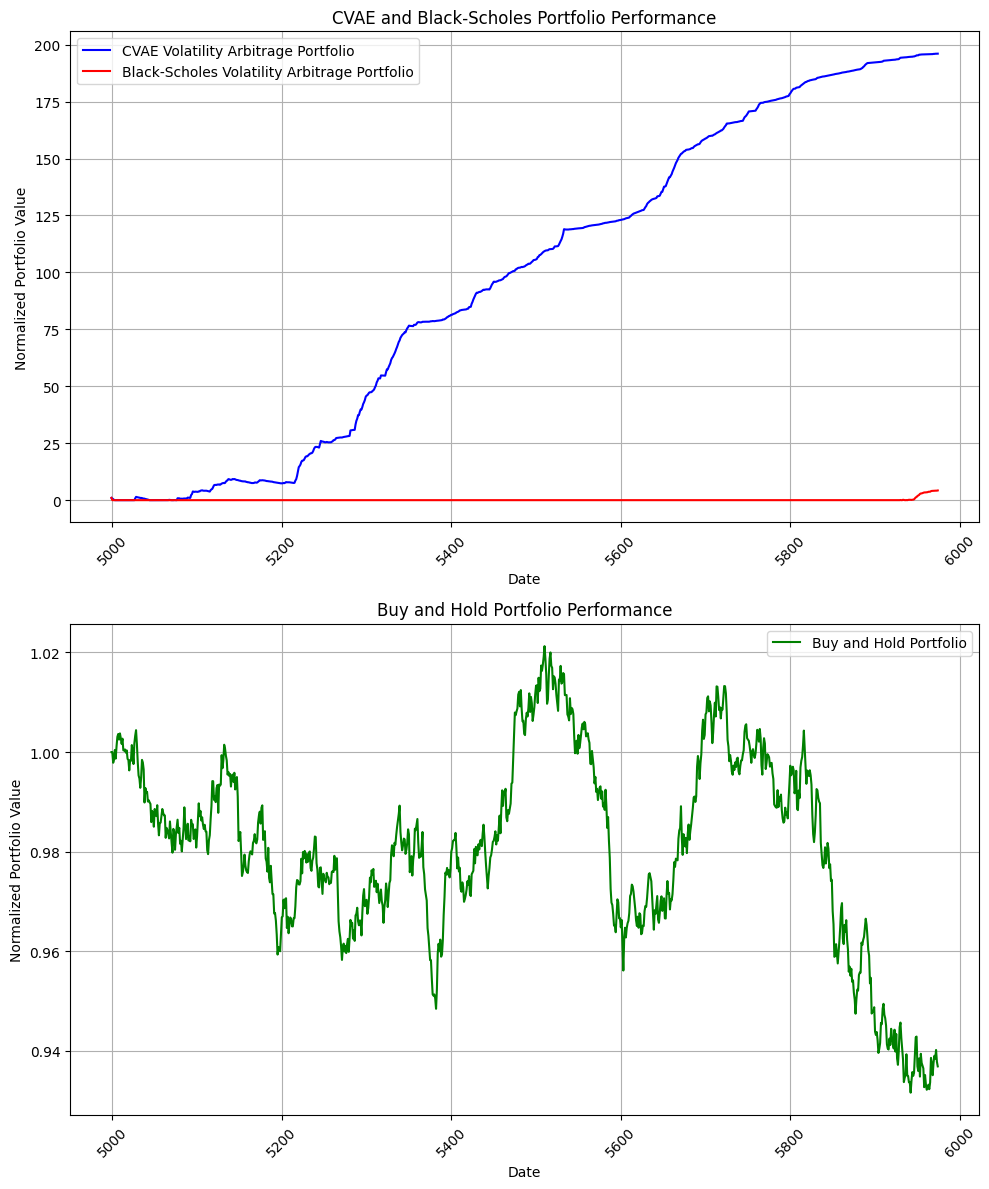

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq, newton, bisect
import matplotlib.pyplot as plt
import random
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
import time
import math
import ast

extra_features_size = 3

# Load the saved model state dictionary
model.load_state_dict(torch.load('best_model.pth'))
print("Model loaded successfully.")
print(model.eval())

# Underlying params for Black-Scholes
r = 0.05  # risk-free rate
longterm_variance = 0.04  # long-term volatility - Heston set

df_orderbook_ts = 'orderbook_ts.csv'
orderbook_ts = pd.read_csv('orderbook_ts.csv')

LOB = np.array([np.array(ast.literal_eval(option)) for option in orderbook_ts['options_data']], dtype=object)
#print(f"LOB: {LOB}")


file_path = 'cvae_training_data.csv'
df = pd.read_csv(file_path)

# Extract IV surfaces and reshape them into 5x5 matrices
X = np.array([np.fromstring(iv_surface[1:-1], sep=' ').reshape(5, 5) for iv_surface in df['iv_surface_flattened']])
Y = df[['skew', 'slope', 'log_returns']].values

# Normalize features
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Flatten the IV surfaces for scaling, then reshape back to (5, 5)
X_flat = np.array([surface.flatten() for surface in X])
x_reshaped = scaler_x.fit_transform(X_flat).reshape(-1, 5, 5)
y_reshaped = scaler_y.fit_transform(Y).reshape(-1, 1, extra_features_size)

iv_surfaces_tensor = TensorDataset(torch.Tensor(x_reshaped), torch.Tensor(y_reshaped))

x = [x[0] for x in iv_surfaces_tensor]
y = [x[1] for x in iv_surfaces_tensor]

N = 10

# Track the value of the portfolios over time - each start with 1000 dollars
cvae_portfolio_value_ts = [1000]
bs_portfolio_value_ts = [1000]
buy_and_hold_portfolio_value_ts = [1000]

cvae_state = {'cash_balance': 1000, 'premiums_recieved': 0, 'stocks_held': 0, 'realised_losses': 0}
bs_state = {'cash_balance': 1000, 'premiums_recieved': 0, 'stocks_held': 0, 'realised_losses': 0}
hold_state = {'cash_balance': 1000, 'stocks_held': 0}

S = orderbook_ts['underlying_price'].values

start_t = 5000
end_t = 5975

initial_asset_price = S[start_t]

##all in on hold porfolio
hold_state['stocks_held'] = math.floor(1000 / initial_asset_price)
hold_state['cash_balance'] -= round(initial_asset_price * hold_state['stocks_held'], 2)

dates = [start_t - 1]

bought_options_cvae = []
bought_options_bs = []

lob_range = len(LOB)
for t in range(start_t, end_t):
    dates.append(t)

    S_t = S[t]
    
    x_c = x[t-31:t]
    y_c = y[t-31:t]

    x_c = torch.stack(x_c)
    y_c = torch.stack(y_c)

    cvae_iv_forecast = predict_iv(x_c, y_c, N)

    cvae_iv_forecast = cvae_iv_forecast.detach().numpy().reshape(-1, 25)
    cvae_iv_forecast = scaler_x.inverse_transform(cvae_iv_forecast).reshape(5,5)

    #print(cvae_iv_forecast)

    ##assess if any bought options have lead to losses
    bought_options_cvae = check_call_option_loss(bought_options_cvae, t)
    bought_options_bs = check_call_option_loss(bought_options_bs, t)

    market_depth_day_t = math.floor(len(LOB[t]) / 2)
    median_strike = LOB[t][market_depth_day_t][0]

    min_strike = LOB[t][0][0]
    max_strike = LOB[t][-1][0]

    #print(f"median strike: {median_strike} || min_strike: {min_strike} || max strike: {max_strike}")

    bought_options_cvae, cvae_state = check_for_profits(cvae_state, LOB[t], bought_options_cvae, median_strike, min_strike, max_strike)
    bought_options_bs, bs_state = check_for_profits(bs_state, LOB[t], bought_options_bs , median_strike, min_strike, max_strike)
    
    for option in LOB[t]:
        strike, ttm, bid, ask, iv = option

        expiration_date = t + int(ttm) * 30

        closest_moneyness_level, diff, moneyness_index, ttm_index = find_closest_moneyness_range_and_ttm(S_t, strike, int(ttm))

        if iv == np.nan or moneyness_index == -1 or expiration_date > 5975:
            continue

        if diff < 0.05:
            ##we buy underpriced options with the expectation the market will correct - iv low
            if  cvae_iv_forecast[ttm_index][moneyness_index] > iv + 0.3:
                #naked buying - then think about going delta neutral
                bought_options_cvae, cvae_state = buy_underpriced_option(cvae_state, bid, bought_options_cvae, expiration_date, strike)

        if  longterm_variance > iv:
            bought_options_bs, bs_state = buy_underpriced_option(bs_state, bid, bought_options_bs, expiration_date, strike)

     ###at the end of the day of trading calculate porfolio values in ts
    cvae_portfolio_value = cvae_state['cash_balance'] + S_t * cvae_state['stocks_held']
    cvae_portfolio_value_ts.append(cvae_portfolio_value)

    ###at the end of the day of trading calculate porfolio values in ts
    bs_portfolio_value = bs_state['cash_balance'] + S_t * bs_state['stocks_held']
    bs_portfolio_value_ts.append(bs_portfolio_value)

    buy_and_hold_portfolio_value = hold_state['cash_balance'] + S_t * hold_state['stocks_held']
    buy_and_hold_portfolio_value_ts.append(buy_and_hold_portfolio_value)

#print(cvae_portfolio_value_ts)
#print( cvae_portfolio_value_ts[0])
#print(len(cvae_portfolio_value_ts))
# Normalize the portfolio values to start at 1
cvae_portfolio_value_ts_norm = np.array(cvae_portfolio_value_ts) / cvae_portfolio_value_ts[0]
bs_portfolio_value_ts_norm = np.array(bs_portfolio_value_ts) / bs_portfolio_value_ts[0]
buy_and_hold_portfolio_value_ts_norm = np.array(buy_and_hold_portfolio_value_ts) / buy_and_hold_portfolio_value_ts[0]

plt.figure(figsize=(10, 12))  # Increased vertical size to accommodate two full-sized plots

# Plot for CVAE and Black-Scholes Portfolios
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(dates, cvae_portfolio_value_ts_norm, label='CVAE Volatility Arbitrage Portfolio', color='blue')
plt.plot(dates, bs_portfolio_value_ts_norm, label='Black-Scholes Volatility Arbitrage Portfolio', color='red')
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')
plt.title('CVAE and Black-Scholes Portfolio Performance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Plot for Buy and Hold Portfolio
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(dates, buy_and_hold_portfolio_value_ts_norm, label='Buy and Hold Portfolio', color='green')
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')
plt.title('Buy and Hold Portfolio Performance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq, newton, bisect
import matplotlib.pyplot as plt
import random
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
import time
import math

# Load the saved model state dictionary
model.load_state_dict(torch.load('best_model.pth'))
print("Model loaded successfully.")
print(model.eval())

# Underlying params for Black-Scholes
r = 0.05  # risk-free rate
longterm_volatility = 0.04  # long-term volatility - Heston set

file_path = 'option_prices_timeseries.csv'
options = pd.read_csv(file_path, index_col=0)

file_path = 'asset_prices.csv'
asset_prices = pd.read_csv(file_path, index_col=0)

file_path = 'combined_iv_data_small.csv'
iv_surfaces = pd.read_csv(file_path, header=[0, 1], index_col=0)

file_path = 'mean_iv_data_small.csv'
mean_surface = pd.read_csv(file_path, index_col=0) #for bs

# Convert DataFrame to NumPy array
mean_surface_array = mean_surface.values

print(mean_surface_array.shape)


y = iv_surfaces[['Log Return', 'Skew', 'Slope']]
x = iv_surfaces.drop(['Log Return', 'Skew', 'Slope'], axis=1)

# Normalize features
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y)

x = np.array(x)
y = np.array(y)

x_reshaped = x.reshape(x.shape[0], H, W)
y_reshaped = y.reshape(y.shape[0], 1, extra_features_size)

iv_surfaces_tensor = TensorDataset(torch.Tensor(x_reshaped), torch.Tensor(y_reshaped))

x = [x[0] for x in iv_surfaces_tensor]
y = [x[1] for x in iv_surfaces_tensor]

sold_options_cvae = []
sold_options_bs = []

bought_options_cvae = []
bought_options_bs = []

N = 10

# Track the value of the portfolios over time - each start with 1000 dollars
cvae_portfolio_value_ts = [1000]
bs_portfolio_value_ts = [1000]
buy_and_hold_portfolio_value_ts = [1000]

cvae_state = {'cash_balance': 1000, 'premiums_recieved': 0, 'stocks_held': 0, 'realised_losses': 0}
bs_state = {'cash_balance': 1000, 'premiums_recieved': 0, 'stocks_held': 0, 'realised_losses': 0}
hold_state = {'cash_balance': 1000, 'stocks_held': 0}

initial_asset_price = options.loc[32]["Asset Price"].iloc[0]
#print(f"inital asset price is: {initial_asset_price}")

##all in on hold porfolio
hold_state['stocks_held'] = math.floor(1000 / initial_asset_price)
hold_state['cash_balance'] -= round(initial_asset_price * hold_state['stocks_held'], 2)

#account for trading frictions loss of 5bp per trade
start_t = 32
end_t = 1032
dates = [start_t - 1]

cvae_times = []
bs_times = []
bs_iv_estimation_times = []
forecast_times = []

longterm_variance = 0.04 #long term average variance
for t in range(start_t, end_t):
    print(t)
    dates.append(t)
    #print(f"cvae porfolio before day {t} of trading: {cvae_portfolio_value_ts[-1]}")
    
    options_t = options.loc[t] #all options for timestep t
    x_c = x[t-31:t]
    y_c = y[t-31:t]

    x_c = torch.stack(x_c)
    y_c = torch.stack(y_c)
    
    S = options.loc[t]["Asset Price"].iloc[0]

    ##assess if any bought options have lead to losses
    bought_options_cvae = check_call_option_loss(bought_options_cvae, t)
    bought_options_bs = check_call_option_loss(bought_options_bs, t)

    ###Selling the call options and tracking them
    for _, selected_row in options_t.iterrows():
        T = selected_row["Time to Maturity (Months)"]  # TTM in months
        K = selected_row["Strike"]
        #print(K)
        market_price_bid_call = selected_row["Bid Call Price"]
        market_price_ask_call = selected_row["Ask Call Price"]
        
        expiration_date = t + int(T) * 30


        iv_start_time = time.time()
        iv = find_iv(market_price_bid_call, S, K, T / 12, r)
        option_iv_estimation_time_taken = time.time() - iv_start_time


        indexing_start_time = time.time()
        closest_moneyness_level, diff, moneyness_index, ttm_index = find_closest_moneyness_range_and_ttm(S, K, int(T))
        indexing_time_taken = time.time() - indexing_start_time
        
        #check if we found any profitable trades
        cvae_buy_cycle_start_time = time.time()
        bought_options_cvae, cvae_state = check_for_profits(market_price_ask_call, bought_options_cvae, cvae_state, int(T), closest_moneyness_level)
        cvae_buy_cycle_time_taken = time.time() - cvae_buy_cycle_start_time

        bs_buy_cycle_start_time = time.time()
        bought_options_bs, bs_state = check_for_profits(market_price_ask_call, bought_options_bs, bs_state , int(T), closest_moneyness_level)
        bs_buy_cycle_time_taken = time.time() - bs_buy_cycle_start_time
        #sanity check
        if iv == np.nan or moneyness_index == 99 or expiration_date > 6000:
            continue

        cvae_forecast_start_time = time.time()
        forecast_iv, time_for_simulation = predict_iv(x_c, y_c, int(T), N, moneyness_index, ttm_index)

        forecast_iv = forecast_iv.detach().numpy().reshape(-1, 25)
        forecast_iv = scaler_x.inverse_transform(forecast_iv)
        forecast_iv = forecast_iv.reshape(5,5)
        cvae_forecast_time_taken = time.time() - cvae_forecast_start_time
        #print(forecast_iv)
        #print(f"bs: {forecast_iv[moneyness_index][ttm_index]} || iv: {iv}")

        cvae_trade_start_time = time.time()
        if diff < 0.1:
            ##we buy underpriced options with the expectation the market will correct
            if  abs(iv) > abs(forecast_iv[ttm_index][moneyness_index]):
                #naked buying - then think about going delta neutral
                bought_options_cvae, cvae_state = buy_underpriced_option(cvae_state, bought_options_cvae, expiration_date, market_price_bid_call, int(T), closest_moneyness_level)
        cvae_trade_time_taken = time.time() - cvae_trade_start_time

        bs_trade_start_time = time.time()
        ##we buy underpriced options with the expectation the market will correct        
        if abs(iv) > longterm_variance:
            bought_options_bs, bs_state = buy_underpriced_option(bs_state, bought_options_bs, expiration_date, market_price_bid_call, int(T), closest_moneyness_level)
        bs_trade_time_taken = time.time() - bs_trade_start_time

        ##GOT ALL THE IMPORTANT TIMINGS FOR EACH NOW CALCULATE TIMINGS
        bs_tt = option_iv_estimation_time_taken + indexing_time_taken + bs_buy_cycle_time_taken + bs_trade_time_taken
        bs_times.append(bs_tt)
    
        cvae_tt = option_iv_estimation_time_taken + indexing_time_taken + cvae_buy_cycle_time_taken + cvae_forecast_time_taken + cvae_trade_time_taken
        cvae_times.append(cvae_tt)

        forecast_times.append(cvae_forecast_time_taken)
        bs_iv_estimation_times.append(option_iv_estimation_time_taken)

    
    ###at the end of the day of trading calculate porfolio values in ts
    cvae_portfolio_value = cvae_state['cash_balance'] + S * cvae_state['stocks_held']
    cvae_portfolio_value_ts.append(cvae_portfolio_value)

    ###at the end of the day of trading calculate porfolio values in ts
    bs_portfolio_value = bs_state['cash_balance'] + S * bs_state['stocks_held']
    bs_portfolio_value_ts.append(bs_portfolio_value)

    buy_and_hold_portfolio_value = hold_state['cash_balance'] + S * hold_state['stocks_held']
    buy_and_hold_portfolio_value_ts.append(buy_and_hold_portfolio_value)

# Normalize the portfolio values to start at 1
cvae_portfolio_value_ts_norm = np.array(cvae_portfolio_value_ts) / cvae_portfolio_value_ts[0]
bs_portfolio_value_ts_norm = np.array(bs_portfolio_value_ts) / bs_portfolio_value_ts[0]
buy_and_hold_portfolio_value_ts_norm = np.array(buy_and_hold_portfolio_value_ts) / buy_and_hold_portfolio_value_ts[0]

plt.figure(figsize=(10, 12))  # Increased vertical size to accommodate two full-sized plots

# Plot for CVAE and Black-Scholes Portfolios
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(dates, cvae_portfolio_value_ts_norm, label='CVAE Volatility Arbitrage Portfolio', color='blue')
plt.plot(dates, bs_portfolio_value_ts_norm, label='Black-Scholes Volatility Arbitrage Portfolio', color='red')
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')
plt.title('CVAE and Black-Scholes Portfolio Performance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Plot for Buy and Hold Portfolio
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(dates, buy_and_hold_portfolio_value_ts_norm, label='Buy and Hold Portfolio', color='green')
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')
plt.title('Buy and Hold Portfolio Performance')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

# Calculate the mean of each list
cvae_mean = np.mean(cvae_times)
bs_mean = np.mean(bs_times)
bs_iv_estimation_mean = np.mean(bs_iv_estimation_times)
forecast_mean = np.mean(forecast_times)

print(f"mean cvae time taken for trade: {cvae_mean}")
print(f"mean bs benchmark time taken for trade: {bs_mean}")
print(f"mean time taken to calculate iv of option using BS: {bs_iv_estimation_mean}")
print(f"mean time taken to forecast iv surface using CVAE: {forecast_mean}")

# Create labels and values for the bar chart
labels = ['CVAE', 'BS', 'BS IV Estimation', 'Forecast']
means = [cvae_mean, bs_mean, bs_iv_estimation_mean, forecast_mean]

# Creating the bar chart
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(labels, means, color=['blue', 'red', 'green', 'purple'])  # Plot bars with different colors
plt.xlabel('Method')
plt.ylabel('Average Time (s)')
plt.title('Average Execution Times')
plt.ylim(0, max(means) + 0.05)  # Set y-limit to give some space above the tallest bar
plt.show()

In [ ]:
# Calculate the mean of each list
bs_iv_estimation_mean = np.mean(bs_iv_estimation_times)
forecast_mean = np.mean(forecast_times)

print(f"mean time taken to calculate iv of option using BS: {bs_iv_estimation_mean}")
print(f"mean time taken to forecast iv surface using CVAE: {forecast_mean}")

# Create labels and values for the bar chart
labels = ['CVAE Forecast Time', 'BS Time', 'CVAE Total Time']
means = [forecast_mean, bs_iv_estimation_mean, forecast_mean + bs_iv_estimation_mean]

# Creating the bar chart
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(labels, means, color=['blue', 'red', 'green', 'purple'])  # Plot bars with different colors
plt.xlabel('Method')
plt.ylabel('Average Time (s)')
plt.title('Average Execution Times')
plt.ylim(0, max(means) + 0.05)  # Set y-limit to give some space above the tallest bar
plt.show()